# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №5 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 15 декабря 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 декабря, -4 балла после 06:00 24 декабря, -6 баллов после 06:00 31 декабря -8 баллов  после 06:00 7 января


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (6 баллов)

###### Боевое применение (2 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

# Определяем, что вам досталось

Укажите свою фамилию на русском языке в поле ниже.

In [1]:
import hashlib

def lucky_hash(text):
    return int(hashlib.md5(text.encode('utf-8')).hexdigest()[:8], 16) 

USER_NAME = u"Bykov".lower()

ALGORITHMS = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - число кластеров)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)",]

print ("Имплементируйте алгоритм кластеризации %s"\
% (
    ALGORITHMS[lucky_hash(USER_NAME[::-1]) % 2]
) )

Имплементируйте алгоритм кластеризации Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - число кластеров)


Не стоит переживать из-за Вашего варианта. Технически оба алгоритма несложно реализовать.  EM алгоритма бояться не стоит, Вам будет нужно просто реализовать уже выведенные формулы для E и M шагов.

In [2]:
import time
import pandas as pd
import pylab as pl
import numpy as np
from sklearn.metrics import pairwise_distances
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать один из двух популярных методов кластеризации: разделение смеси нормальных распределений или агломеративную кластеризацию. 

## Смесь нормальных распределений



Предполагаем, что наши данные порождены смесью $k$ нормальных распределений, то есть 

$$ p(\mathbf{x}) = \sum_k \pi_k \mathcal{N}(\mathbf{x} | \mathbf{\mu}_k, \mathbf{\Sigma}_k) $$,


где $\mathcal{N}$ - многомерное нормальное распределение размерности ${D}$:

$$\mathcal{N(\mathbf{x} | \mathbf{\mu}, \mathbf{\Sigma}}) = \frac{1}{(2 \pi)^{D/2}} \frac{1}{|\mathbf{\Sigma}|^{1/2}} \exp \left\{-\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma^{-1}} (\mathbf{x} - \mathbf{\mu})\right\}$$

**Параметры**  


${D}$-мерный вектор средних

$$\mathbf{\mu}$$

$D \times D$-мерная матрица ковариации   (симметричная)


$$\mathbf{\Sigma} = E[(\mathbf{x} - \mathbf{\mu})(\mathbf{x} - \mathbf{\mu})^T]$$



Необходимо оценить параметры $\pi_k, \mathbf{\mu_k}, \mathbf{\Sigma_k} $ для всех компонент смеси.  Сделать это можно с помощью EM алгоритма - алгоритма, который находит оценку максимального правдоподобия в задаче со скрытыми переменными. 

## Expectation Maximization

**I** До цикла проинциализировать случайно  $\mu_k, \Sigma_k, \pi_k$ ($\pi_k$ должны суммироваться в 1)

**E** Expectation: при фиксированных $\mu_k, \Sigma_k, \pi_k$
$$
p(z_k = 1| x_n ) = \gamma(z_{nk}) = \frac{\pi_k \mathcal{N} (\mathbf{x}_n | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N} (\mathbf{x}_n | \mu_j, \Sigma_j)}
$$
**M** Maximization: при фиксированных $\gamma(z_{nk})$
$$
N_k = \sum_{n=1}^N \gamma(z_{nk}), \;\; \mu_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) \mathbf{x}_n
$$
$$
\Sigma_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n - \mu_k)(\mathbf{x}_n - \mu_k)^T
$$
$$
\pi_k = \frac{N_k}{N}
$$
**S** Остановиться при достижении сходимости

Номер кластера для $n$ объекта будем брать по принципу maximum a-posteriori, то есть относить объект к тому кластеру, у которого максимальна апостериорная вероятность:
$$ k_n =  \arg\underset{k}\max  p(z_k = 1| x_n ) =  \arg\underset{k}\max \gamma(z_{nk}) $$

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Для простоты будем использовать евклидово расстояние между объектами.



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.




***Ваше решение здесь***


$k$ $-$ число кластеров, $N$ $-$ число объектов => $k^N$ вариантов возможных разметок объектов(каждый объект может иметь 1 из $k$ меток)
мы минимизируем 
$$ L(C) = \sum_{k=1}^K\sum_{i\in C_k} ||x_i - \mu_k||^2 \rightarrow \min\limits_C $$
$$\mu_k = \frac{1}{|C_k|} \sum _{x_n \in C_k} x_n$$


Множество значений ограниченно => минимум существует => не более чем за $k^N$(не медленнее  чем переберем все эллементы) мы найдем минимум(но возможно локальный)

Задача 2. Сходимость EM.

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?


***Ваше решение здесь***


Будет сходиться когда функция правдоподобия непрерывна на замкнутом ограниченном множестве, а выборка из этого множества(так как здесь существует как минимум один максимум и функция будет двигаться в сторону одного из них), но скорее всего это условие можно ослабить

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

$ a = \frac{1}{2} * ((a+b) + (a - b))   $


$ b = \frac{1}{2} * ((a+b) + (b - a))   $


Если a>b
$ max(a, b) = a = \frac{1}{2} * ((a+b) + (a - b))   $ если b>a $ max(a, b) = b = \frac{1}{2} * ((a+b) + (b - a))   $ => $ max(a, b) =  \frac{1}{2} * ((a+b) + |a - b|)   $


$d_{\max}(U \cup V, S) = max(d_{\max}(U, S),  d_{\max}(V, S)) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $

# Реализация алгоритма кластеризации  (6 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [3]:
from sklearn.base import BaseEstimator, ClusterMixin


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according
    """

    def __init__(self, n_clustrers, accuracy=0.01):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.n_clustrers = n_clustrers
        self.accur = accuracy
        return

    def Normal(self, X, k):
        stX = (X - self.mu[k])
        a = np.exp(-0.5 * (((stX))**2).sum(axis=1) /
                   (self.sigma[k] + 0.0001)) / (self.sigma[k]**(1 / 2)
                                                + 0.0001)
        return a

    def Estep(self, X):
        for k in range(self.n_clustrers):
            self.gamma[k] = self.pi[k] * self.Normal(X, k)
        self.gamma = self.gamma / (self.gamma.sum(axis=0).reshape(1, -1))

    def Pstep(self, X):
        N = np.zeros(self.n_clustrers)
        for k in range(self.n_clustrers):
            N[k] = self.gamma[k].sum() + 1
            K = self.gamma[k].reshape(-1, 1)
            self.mu[k] = (X * K).sum(axis=0) / N[k]
            self.sigma[k] = (K * ((X - self.mu[k])**2)
                             ).mean(axis=1).sum() / (N[k] + 0.001)
        self.pi = N / (N.sum())

    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.x_len = len(x)
        self.sigma = np.random.randint(1000, size=self.n_clustrers) / 1000
        self.pi = np.random.randint(100, size=self.n_clustrers) + 6
        self.pi = self.pi / self.pi.sum()
        self.mu = x[np.random.randint(0, x.shape[0], self.n_clustrers)]
        self.gamma = np.zeros(
            x.shape[0] *
            self.n_clustrers).reshape(
            self.n_clustrers,
            x.shape[0])
        mu = self.mu
        pi = self.pi
        last = 0
        chn = 100
        i = 0
        while(i < 10000 and (chn > self.accur or last < 5)):
            pi = self.pi.copy()
            self.Estep(x)
            self.Pstep(x)
            last += 1
            i += 1
            if i % 1000 == 0 or (
                np.unique(
                    np.argmax(
                        self.gamma,
                        axis=0)).shape[0] < self.n_clustrers):
                self.mu = x[np.random.randint(0, x.shape[0], self.n_clustrers)]
                self.gamma = np.zeros(
                    x.shape[0] * self.n_clustrers).reshape(self.n_clustrers,
                                                           x.shape[0])
                self.pi = np.random.randint(100, size=self.n_clustrers) + 5
                self.pi = self.pi / self.pi.sum()
                last = 0
            else:
                chn = ((pi - self.pi)**2).sum()
        return self

    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        self.gamma = np.zeros(
            x.shape[0] *
            self.n_clustrers).reshape(
            self.n_clustrers,
            x.shape[0])
        self.Estep(x)
        return np.argmax(self.gamma, axis=0)

In [4]:
a = np.array([1.5,2,0.0123,4]).reshape(2, 2)
a.sum(axis=0)
a.prod()

0.1476

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

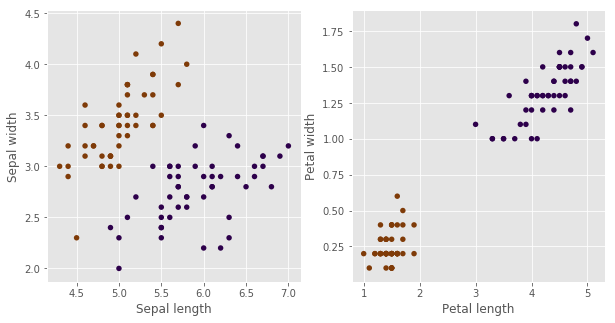

In [5]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [6]:
# pred_iris = Clustering().fit_predict(x_iris)
pred_iris = [ 0 ] * len(y_iris)
print ("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 0.00


In [7]:
# Давайте проверим, как справляются sklearn реализации
sklearn_gmm = GaussianMixture(n_components=2)
gmm_t0 = time.time()
sklearn_gmm.fit(x_iris)
gmm_diff = time.time() - gmm_t0
gmm_score = smt.adjusted_rand_score(y_iris, sklearn_gmm.predict(x_iris))
#print(sklearn_gmm.predict(x_iris))

sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("GMM score {}. GMM time {}. AGGL score {}. AGGL time {}".format(gmm_score, gmm_diff, aggl_score, aggl_diff))

GMM score 1.0. GMM time 0.00549006462097168. AGGL score 1.0. AGGL time 0.005156040191650391


In [8]:
gmm = Clustering(n_clustrers=2)
gmm.fit(x_iris)
gmm.predict(x_iris)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
gmm = Clustering(n_clustrers=2)
gmm_t0 = time.time()
gmm.fit(x_iris)
gmm_score = smt.adjusted_rand_score(y_iris, sklearn_gmm.predict(x_iris))
gmm_diff = time.time() - gmm_t0    
print(gmm_diff, gmm_score)

0.004320383071899414 1.0


Сверьте Ваш алгоритм с этими числами. Уверен, что у Вас получится не хуже!

# Боевое применение (2  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для анализа реальной задачи!

Важное замечание: в этой части задания студенту самому предлагается разобраться с данными и их форматом в качестве полезного упраженения. Не принимайте это близко к сердцу :)

Ввозьмем датасет различных стран.  
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   


Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам. 
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   

Необходимо показать, какие страны попали в общий кластер в и объяснить из-за каких признаков это произошло. Если страны были в одном кластере, а спустя несколько лет разъехались по разным кластерам, попробуйте это объяснить. 

In [10]:
# Место для Вашего кластерного анализа

In [11]:
df_sns = pd.read_csv('WDI_csv/WDIData.csv', sep=',')
df_sns.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Arab World,ARB,"2005 PPP conversion factor, GDP (LCU per inter...",PA.NUS.PPP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"2005 PPP conversion factor, private consumptio...",PA.NUS.PRVT.PP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,81.844982,82.407647,82.827636,83.169227,83.587141,83.954293,84.230630,84.570425,NaN,NaN
3,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,85.189815,86.136134,86.782683,87.288244,88.389705,88.076774,88.517967,88.768654,NaN,NaN
4,Arab World,ARB,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,73.530494,74.543489,75.770972,76.772916,78.839139,77.487377,78.564439,78.958780,NaN,NaN


In [12]:
df = df_sns.drop('Country Code',axis=1) 
df = df.drop('Indicator Code', axis=1)
df = df.drop('Unnamed: 62', axis=1)
df = df.drop('2017', axis=1)
df = df.drop('1960', axis=1)
df = df.dropna(axis=0)
df.shape

(35100, 58)

In [13]:
s = set()
d = dict()
d1 = dict()
df[['Country Name', 'Indicator Name']]
for i in df[['Country Name', 'Indicator Name']].values:
    if (i[1] not in s):
        s.add(i[1])
    if (i[0] in d.keys()):
        d[i[0]] = d[i[0]] + [i[1]]
    else:
        d[i[0]] =  [i[1]]
thr = dict()
for j in d.keys():
    for i in s:
        if i not in d[j]:
            if (i in thr):
                thr[i] += 1
            else:
                thr[i] = 1
badcountry = set()
badIndex = set()
for j in d.keys():
    for i in s:
        if i not in d[j]:
            if thr[i] < 50:
                if j not in badcountry:
                    badcountry.add(j)
            else:
                if i not in badIndex:
                    badIndex.add(i)
goodIndex = set()
goodcountry = set()
for i in s:
    if i not in badIndex:
        print(i)
        goodIndex.add(i)
len(badcountry)
for j in d.keys():
    if j not in badcountry:
        print(j)
        goodcountry.add(j)
#print(thr)

Total fisheries production (metric tons)
Population ages 55-59, female (% of female population)
Age dependency ratio, young (% of working-age population)
Population ages 5-9, female (% of female population)
Population ages 35-39, female (% of female population)
Urban population
Land area (sq. km)
Rural population (% of total population)
Population ages 15-19, male (% of male population)
Population ages 25-29, male (% of male population)
Fertility rate, total (births per woman)
Urban population (% of total)
Population ages 65 and above, female (% of total)
Population, male (% of total)
Rural population growth (annual %)
Population ages 0-4, female (% of female population)
Population density (people per sq. km of land area)
Population ages 15-64, female (% of total)
Population ages 35-39, male (% of male population)
Population ages 30-34, male (% of male population)
Population ages 70-74, male (% of male population)
Population ages 65 and above, female
Population ages 5-9, male (% of mal

In [14]:
X = np.zeros(len(goodcountry) * len(goodIndex)).reshape(len(goodcountry), len(goodIndex))
c1 = -1
c2 = 0
df
l = list(goodcountry)
sorted(l)
for j in l:
    df1 = df[['Country Name', 'Indicator Name', '1984']]
    c1 += 1
    c2 = 0
    for i in df1[df1['Country Name']==j].values:
        if(i[1] in goodIndex):
            X[c1][c2] = i[2]
            c2 += 1
#scaler = StandardScaler()
#scaler.fit(X)
#X=scaler.transform(X)
X -= X.min(axis=0)
X /= X.max(axis=0)
gmm = Clustering(n_clustrers=6, accuracy=0.1)
gmm.fit(X)
y = gmm.predict(X)
dfl = pd.DataFrame(l)
for i in range(6):
    print(dfl[y == i], dfl[y == i].shape[0])

                                                     0
7                                               Brazil
11                                             Ecuador
14                              Caribbean small states
16                                  Dominican Republic
36   Latin America & the Caribbean (IDA & IBRD coun...
69                           Latin America & Caribbean
89                                             Lebanon
100                                           Suriname
111                                               Peru
127                                            Tunisia
128                                             Turkey
144                                           Colombia
149                                             Panama
156                                           Malaysia
157                                      Venezuela, RB
160                                       Small states
162  Latin America & Caribbean (excluding high income) 17
       

In [15]:
years = range(1961, 2017)
clusters_labels = np.zeros((len(years), len(goodcountry)))
for year in years:
    X = np.zeros(len(goodcountry) * len(goodIndex)).reshape(len(goodcountry), len(goodIndex))
    c1 = -1
    c2 = 0
    df
    l = list(goodcountry)
    sorted(l)
    for j in l:
        df1 = df[['Country Name', 'Indicator Name', str(year)]]
        c1 += 1
        c2 = 0
        for i in df1[df1['Country Name']==j].values:
            if(i[1] in goodIndex):
                X[c1][c2] = i[2]
                c2 += 1
    X -= X.min(axis=0)
    X /= X.max(axis=0)
    y = gmm.predict(X)
    clusters_labels[year - 1961] = y
    dfl = pd.DataFrame(l)

In [16]:
clusters_labels

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 5., ..., 1., 5., 1.],
       [1., 1., 0., ..., 1., 5., 1.],
       [1., 1., 5., ..., 1., 5., 1.]])

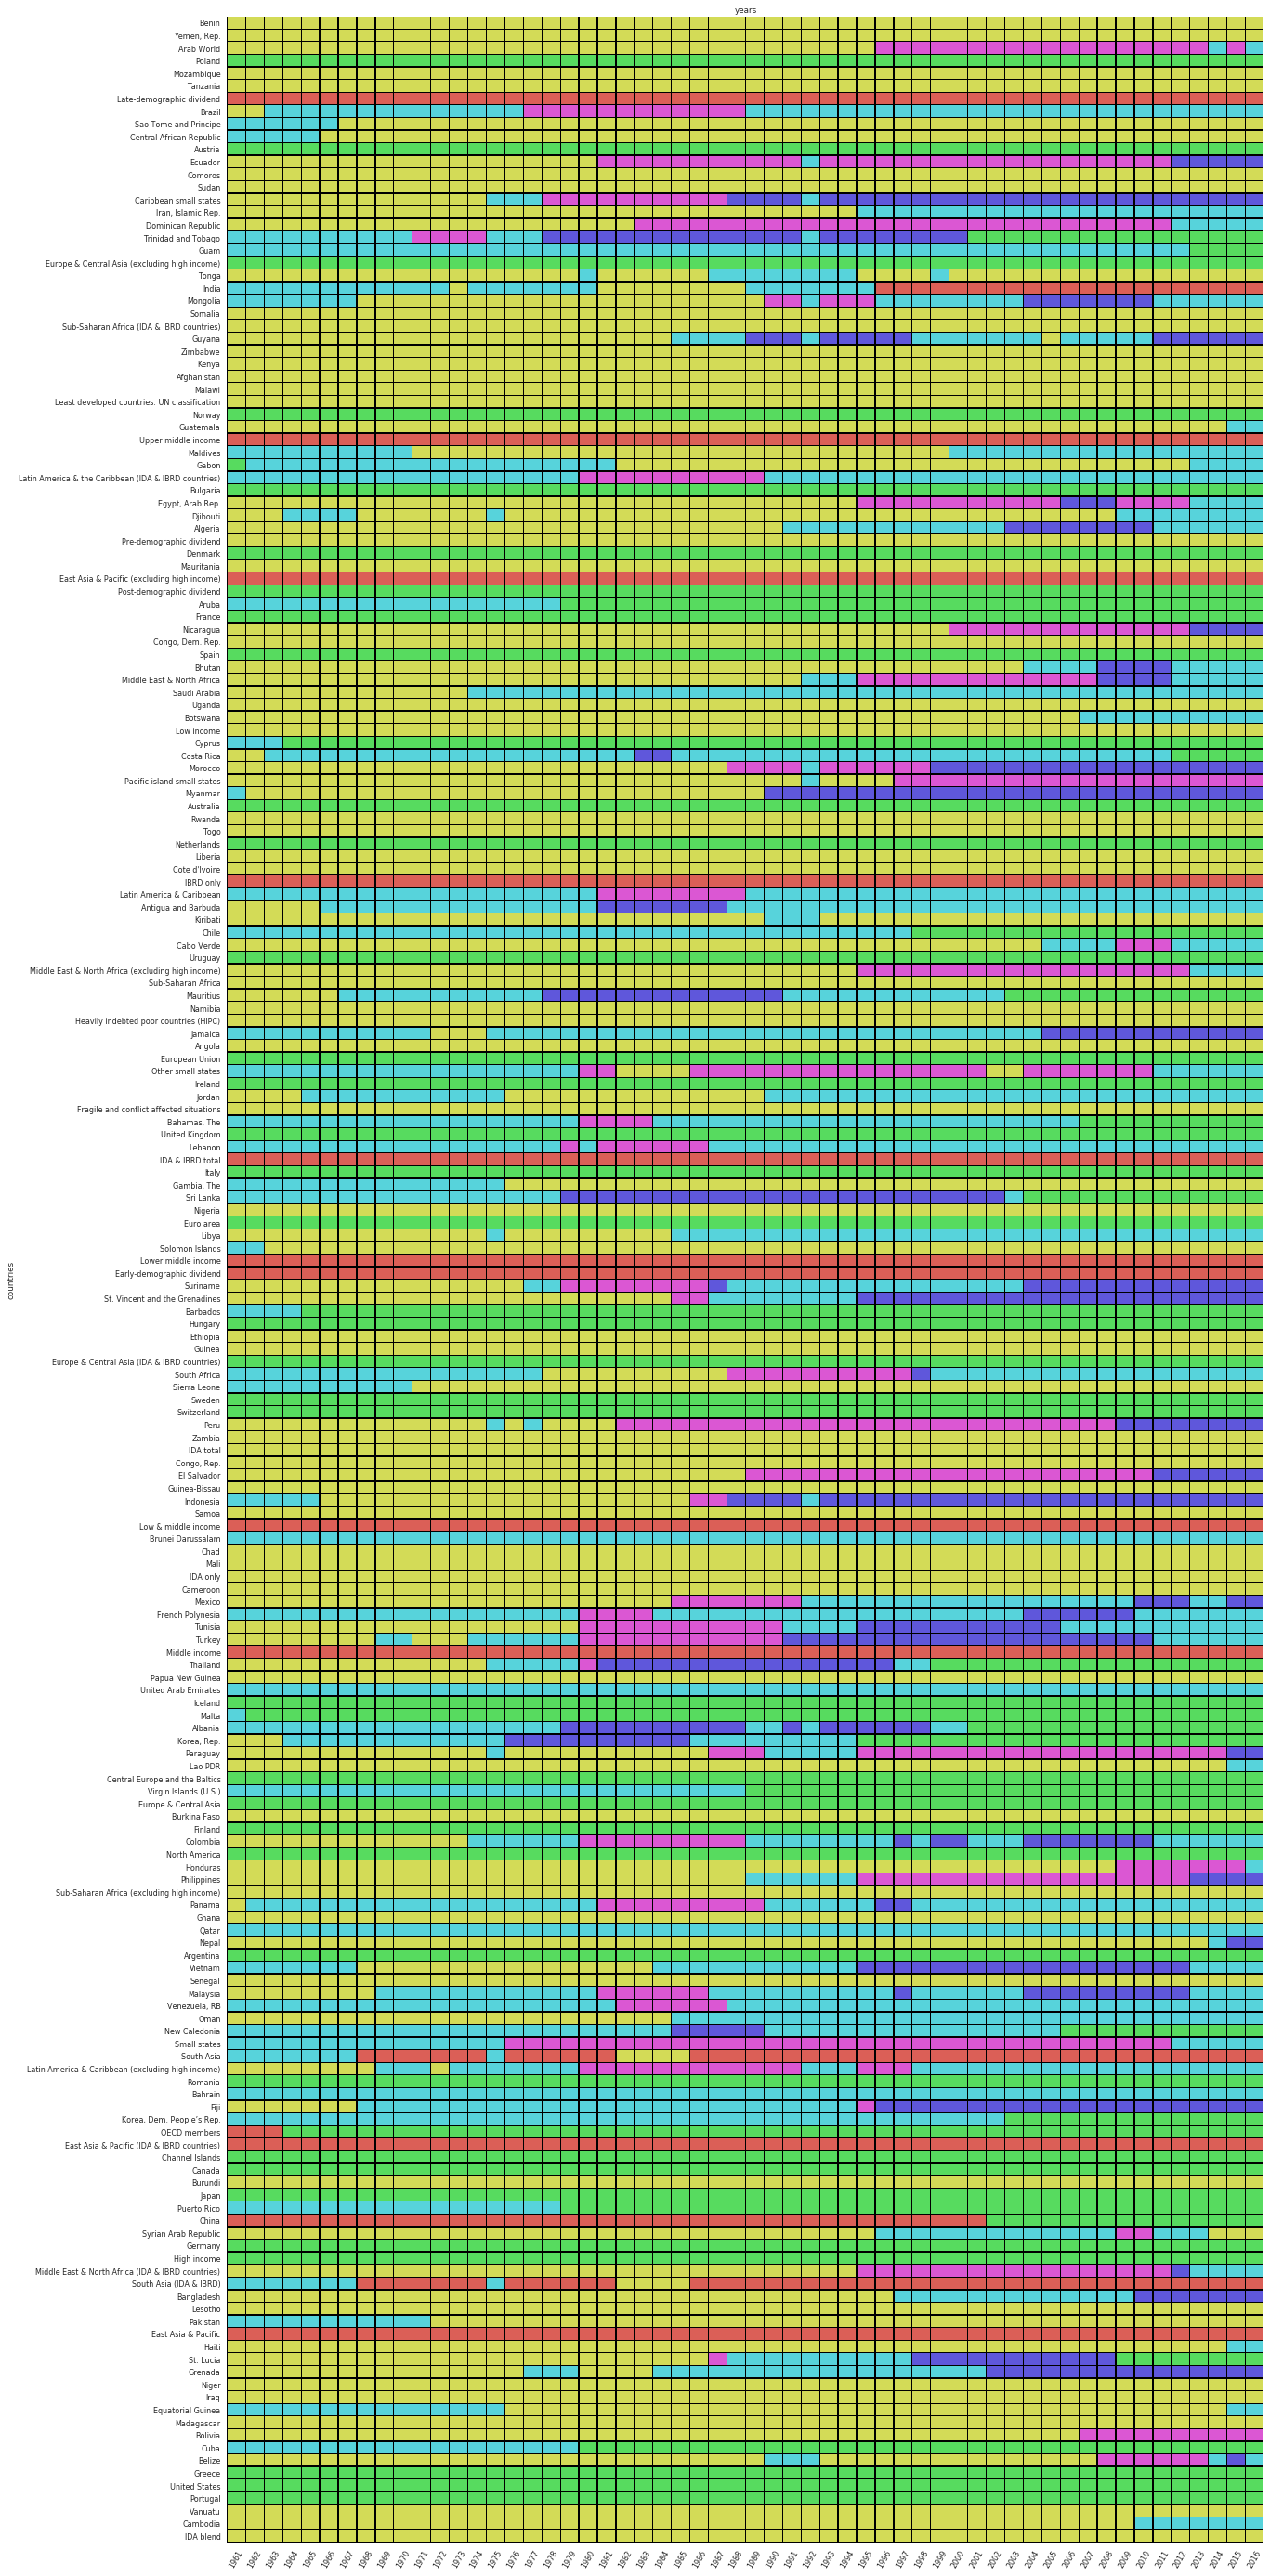

In [17]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

sns.set(font_scale=0.8, rc={'figure.figsize':(20,50)})
cmap = np.random.permutation(sns.color_palette("hls", 6))
cmap = [tuple(color) for color in cmap]
ax = sns.heatmap(clusters_labels.T, cmap=cmap, cbar=False, linewidths=.3, linecolor='black')

ax.set_ylabel('countries')
ax.set_xlabel('years')

ax.xaxis.set_label_position('top')
locs, labels = plt.xticks()
plt.xticks(locs, years)
locs, labels = plt.xticks()
plt.setp(labels, rotation=60)
locs, labels = plt.yticks()
plt.yticks(locs, l)

plt.show()

Зеленый кластер - это европейские страны, США, Япония и тд. С годами этот кластер увеличивается так как в некоторык страны проникает европейская культура. Бирюзовые страны это постоянно Катар Бахрейн ОАЭ и тд, он также расширяется так как с этих стран идет влияние на другие. Китай(долгое время) и регионы был в красном кластере видиом это по неселению и по территории

In [18]:
# Не переживайте, мне тоже было тяжело разобраться с данными

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации? Для тех задач для которых мне тяжело найти обучающую выборку, но при этом есть польза от нахождения похожих данных

***Ваше ответ здесь***

 * Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация? 1ый нужно задавать количество кластеров плюс они имеет круглую форму, зато известны центры и легко интерперетируются(можно посмотреть значения центоров) 2ой +ы кластеры любой формы количество определяется параметрами 3ий после кластеризации известны разбиения для любого количества кластеров и нет элемента случайности

***Ваше ответ здесь***

* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со скрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия? Может быть когда непонятно распределение или кластеры имеют специальную форму (например сферы)

***Ваше ответ здесь***

* Многие алгоритмы анализа данных страдают "проклятием" размерности. Страдают ли этим проклятием алгоритмы кластеризации? Если да, то как бы Вы с этим боролись? Страдают, в случае если мы ничего заранее не знаем о данных,  то попробовал мы запускать с рандомными признаками несколько раз

***Ваше ответ здесь***

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи? выделил бы слова, выкинул бы предлоги и тд нашел бы частоту их встреч - это признаки. А алгоритм например EM 

***Ваше ответ здесь***

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning) с неоторыми небольшими изменениями в алгоритме думаю да

***Ваше ответ здесь***

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***